<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Import Required libraries</b></font>
</p>



In [ ]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import random
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.model_selection import train_test_split
from numpy.linalg import norm
from tensorflow.keras.callbacks import ReduceLROnPlateau


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b> load Dataset</b></font>
</p>

Selected classes: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24']
Train images shape: (105, 224, 224, 3)
Train labels shape: (105,)


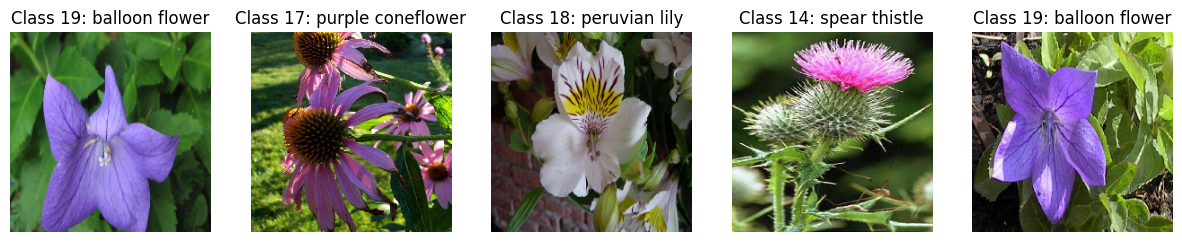

In [ ]:
# Dataset directory path
data_dir = "/kaggle/input/oxford-102-flower-dataset/102 flower/flowers"

# Load JSON file containing class names
class_to_name_path = "/kaggle/input/oxford-102-flower-dataset/102 flower/cat_to_name.json"
with open(class_to_name_path, 'r') as f:
    class_names_dict = json.load(f)

train_dir = os.path.join(data_dir, "test")


all_classes = sorted(os.listdir(train_dir))

# Select the first 20 classes
selected_classes = all_classes[:20]
print("Selected classes:", selected_classes)

# Load images and labels for the selected classes
train_images = []
train_labels = []

for folder in selected_classes:
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            train_images.append(img_array)
            train_labels.append(int(folder))


train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Print the shapes of the arrays
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)


train_class_names = [class_names_dict[str(label)] for label in train_labels]

# Randomly select 5 images from different classes
random_indices = random.sample(range(len(train_images)), 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, idx in enumerate(random_indices):
    axes[i].imshow(train_images[idx])
    axes[i].set_title(f"Class {train_labels[idx]}: {train_class_names[idx]}")
    axes[i].axis('off')
plt.show()


<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Selected Support Set and Query Set and Siamese Train Set</b></font>
</p>

In [ ]:

def create_support_query_siamese_train_sets(train_images, train_labels, class_names_dict, n_classes=3, n_shots=3):
    unique_classes = np.unique(train_labels)
    selected_classes = random.sample(list(unique_classes), n_classes)

    support_images = []
    support_labels = []
    query_images = []
    query_labels = []

    used_indices = set()

    print("Selected classes for Support Set and Query Set:", selected_classes)

    query_distribution = [2, 1, 1]

    for idx, class_id in enumerate(selected_classes):
        class_indices = np.where(train_labels == class_id)[0]
        class_images = train_images[class_indices]

        # Select support set
        support_set_indices = random.sample(list(class_indices), n_shots)
        support_images.extend(train_images[support_set_indices])
        support_labels.extend([class_id] * n_shots)
        used_indices.update(support_set_indices)

        # Select query set
        query_set_indices = [i for i in class_indices if i not in support_set_indices]
        n_query = query_distribution[idx]
        selected_query_indices = random.sample(query_set_indices, n_query)

        query_images.extend(train_images[selected_query_indices])
        query_labels.extend([class_id] * n_query)
        used_indices.update(selected_query_indices)

        print(f"\nClass {class_id} ({class_names_dict[str(class_id)]}):")
        print(f"Indices of images selected for Support Set: {support_set_indices}")
        print(f"Indices of images selected for Query Set: {selected_query_indices}")

    # Select remaining images for Siamese training (all unused images)
    siamese_train_indices = [i for i in range(len(train_labels)) if i not in used_indices]
    siamese_train_images = train_images[siamese_train_indices]
    siamese_train_labels = train_labels[siamese_train_indices]

    return (np.array(support_images), np.array(support_labels),
            np.array(query_images), np.array(query_labels),
            np.array(siamese_train_images), np.array(siamese_train_labels))


support_images, support_labels, query_images, query_labels, siamese_train_images, siamese_train_labels = create_support_query_siamese_train_sets(train_images, train_labels, class_names_dict)


print("*************************")

print("Support Set images shape:", support_images.shape)
print("Support Set labels shape:", support_labels.shape)

print("*************************")

print("Query Set images shape:", query_images.shape)
print("Query Set labels shape:", query_labels.shape)

print("*************************")

print("Siamese Train images shape:", siamese_train_images.shape)
print("Siamese Train labels shape:", siamese_train_labels.shape)


Selected classes for Support Set and Query Set: [100, 13, 2]

Class 100 (blanket flower):
Indices of images selected for Support Set: [15, 13, 9]
Indices of images selected for Query Set: [14, 10]

Class 13 (king protea):
Indices of images selected for Support Set: [49, 46, 48]
Indices of images selected for Query Set: [44]

Class 2 (hard-leaved pocket orchid):
Indices of images selected for Support Set: [86, 82, 83]
Indices of images selected for Query Set: [84]
*************************
Support Set images shape: (9, 224, 224, 3)
Support Set labels shape: (9,)
*************************
Query Set images shape: (4, 224, 224, 3)
Query Set labels shape: (4,)
*************************
Siamese Train images shape: (92, 224, 224, 3)
Siamese Train labels shape: (92,)


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Show Support and Query Sets</b></font>
</p>

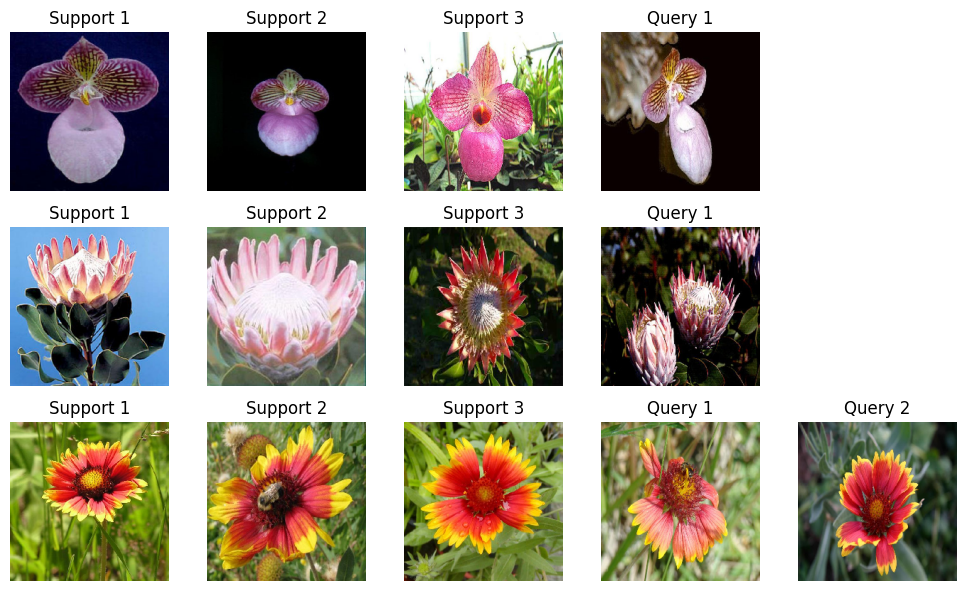

In [ ]:
def visualize_support_query_sets(support_images, support_labels, query_images, query_labels, class_names_dict):
    unique_classes = np.unique(support_labels)

    num_classes = len(unique_classes)
    num_cols = 3 + 2

    fig, axes = plt.subplots(num_classes, num_cols, figsize=(num_cols * 2, num_classes * 2))

    if num_classes == 1:
        axes = [axes]

    for row_idx, class_id in enumerate(unique_classes):
        # Get support images for the class
        support_idxs = np.where(support_labels == class_id)[0]
        support_imgs = support_images[support_idxs]

        # Get query images for the class
        query_idxs = np.where(query_labels == class_id)[0]
        query_imgs = query_images[query_idxs]

        # Normalize images if needed (Check pixel range)
        def preprocess_image(image):
            """ Convert images to uint8 format if necessary. """
            if image.max() <= 1:
                image = (image * 255).astype(np.uint8)
            return image

        # Display support images
        for i in range(3):
            img = preprocess_image(support_imgs[i])
            axes[row_idx, i].imshow(img)
            axes[row_idx, i].set_title(f"Support {i+1}")
            axes[row_idx, i].axis("off")

        # Display query images
        for j in range(len(query_imgs)):
            img = preprocess_image(query_imgs[j])
            axes[row_idx, j + 3].imshow(img)
            axes[row_idx, j + 3].set_title(f"Query {j+1}")
            axes[row_idx, j + 3].axis("off")

        # Hide any remaining empty subplots
        for k in range(len(query_imgs) + 3, num_cols):
            axes[row_idx, k].axis("off")

    plt.tight_layout()
    plt.show()


visualize_support_query_sets(support_images, support_labels, query_images, query_labels, class_names_dict)


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Create pairs for Siamese Train</b></font>
</p>

In [ ]:

def create_pairs_siamese_train_images(siamese_train_images, siamese_train_labels, max_pairs=6480):
    siamese_train_pairs = []
    siamese_train_labels_pairs = []


    all_pairs = []
    all_labels = []

    for i in range(len(siamese_train_images)):
        for j in range(len(siamese_train_images)):
            if i != j:
                all_pairs.append([siamese_train_images[i], siamese_train_images[j]])
                label = 1 if siamese_train_labels[i] == siamese_train_labels[j] else 0
                all_labels.append(label)

    # Shuffle the pairs to ensure randomness
    combined = list(zip(all_pairs, all_labels))
    random.shuffle(combined)

    # Limit the number of pairs to max_pairs
    if len(combined) > max_pairs:
        combined = random.sample(combined, max_pairs)

    # Unpack sampled pairs and labels
    siamese_train_pairs, siamese_train_labels_pairs = zip(*combined)

    # Convert to numpy arrays
    siamese_train_pairs = np.array(siamese_train_pairs)
    siamese_train_labels_pairs = np.array(siamese_train_labels_pairs)

    # Display statistics
    print(f"Total pairs for Siamese Train: {len(siamese_train_pairs)}")
    print(f"Number of similar pairs: {sum(siamese_train_labels_pairs)}")
    print(f"Number of dissimilar pairs: {len(siamese_train_labels_pairs) - sum(siamese_train_labels_pairs)}")

    return siamese_train_pairs, siamese_train_labels_pairs


# Call the function
siamese_train_pairs, siamese_train_labels_pairs = create_pairs_siamese_train_images(
    siamese_train_images, siamese_train_labels, max_pairs=3000
)


Total pairs for Siamese Train: 3000
Number of similar pairs: 164
Number of dissimilar pairs: 2836


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Build the Feature Extractor Model</b></font>
</p>

In [ ]:
def build_feature_extractor():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False


    x = layers.Flatten()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)


    # Create the model with the input being from ResNet50 and output from the dense layer
    feature_extractor = models.Model(inputs=base_model.input, outputs=x)

    print("Feature extractor model has been successfully built.")

    return feature_extractor


model = build_feature_extractor()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Feature extractor model has been successfully built.


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Building a Siamese model with Contrastive Loss Function</b></font>
</p>

In [ ]:

#Contrastive Loss function
def contrastive_loss(y_true, y_pred, margin=1.0, similar_weight=1, dissimilar_weight=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.reshape(y_true, (-1, 1))

    # Calculate the distance between the two feature vectors (feat_a and feat_b)
    distance = tf.sqrt(tf.reduce_sum(tf.square(y_pred[0] - y_pred[1]), axis=-1, keepdims=True) + 1e-7)
    distance = tf.clip_by_value(distance, 1e-7, 1e7)

    # Compute the contrastive loss
    loss = tf.reduce_mean(y_true * similar_weight * tf.square(distance) +
                          (1 - y_true) * dissimilar_weight * tf.square(tf.maximum(margin - distance, 0)))

    return loss



# Define Mean Squared Error (MSE) as a metric
def mse_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Build Siamese model
def build_siamese_model():
    feature_extractor = build_feature_extractor()

    input_a = layers.Input(shape=(224, 224, 3))
    input_b = layers.Input(shape=(224, 224, 3))

    #  Extract features
    feat_a = feature_extractor(input_a)
    feat_b = feature_extractor(input_b)

    # Fix Lambda layer for correct distance computation
    distance = layers.Lambda(lambda tensors: tf.expand_dims(
        tf.sqrt(tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=-1) + 1e-7), axis=-1)
    )([feat_a, feat_b])

    #  Create Siamese model
    siamese_network = models.Model(inputs=[input_a, input_b], outputs=distance)

    # compile
    siamese_network.compile(
        optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
        loss=contrastive_loss,
        metrics=[mse_metric]
    )

    return siamese_network

# Build the Siamese model
siamese_model = build_siamese_model()

# Display model summary
siamese_model.summary()

Feature extractor model has been successfully built.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 64)             │     36,441,152 │ input_layer_2[0][0],   │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ functional_1[0][0],    │
│                           │                        │                │ functional_1[1][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 36,441,152 (139.01 MB)

 Trainable params: 12,853,440 (49.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Fit Model</b></font>
</p>

In [ ]:
# Split the pairs and labels into training and validation sets
train_pairs, validation_pairs, train_labels, validation_labels = train_test_split(
    siamese_train_pairs, siamese_train_labels_pairs, test_size=0.2, random_state=42
)


# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Fit
siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]],
    train_labels,
    epochs=20,
    batch_size=32,
    validation_data=(
        [validation_pairs[:, 0], validation_pairs[:, 1]],
        validation_labels
    ),
    callbacks=[ reduce_lr]
)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 344ms/step - loss: 1.0009 - mse_metric: 363.8822 - val_loss: 0.1861 - val_mse_metric: 1.3083 - learning_rate: 1.0000e-04
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - loss: 2.1108 - mse_metric: 308.4117 - val_loss: 0.2399 - val_mse_metric: 0.4744 - learning_rate: 1.0000e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - loss: 0.9165 - mse_metric: 73.2826 - val_loss: 0.3392 - val_mse_metric: 0.1015 - learning_rate: 1.0000e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2694 - mse_metric: 2.4562
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - loss: 0.2701 - mse_metric: 2.4512 - val_loss: 0.4666 - val_mse_metric: 0.0580 - learning_rate: 1.0000e-04
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - loss: 0.4732 - mse_metric: 0.0530 - val_loss: 0.4666 - val_mse_metric: 0.0580 - learning_rate: 5.0000e-05
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Save the Siamese Model</b></font>
</p>

In [ ]:
siamese_model.save('siamese_model.h5')


<p style="text-align:center;">
    <font face="Georgia" size=6 color="red"><b>Few Shot Learning</b></font>
</p>

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Create Pairs from Support Set</b></font>
</p>

In [ ]:
def create_pairs_support_images(support_images, support_labels):
    support_pairs = []
    support_labels_pairs = []

    # Generate pairs for the support set
    for i in range(len(support_images)):
        for j in range(len(support_images)):
            if i != j:
                pair = [support_images[i], support_images[j]]
                support_pairs.append(pair)
                label = 1 if support_labels[i] == support_labels[j] else 0
                support_labels_pairs.append(label)

    # Display the number of pairs and the distribution of similar/dissimilar pairs
    print(f"Total pairs for support: {len(support_pairs)}")
    print(f"Number of similar pairs for support: {sum(support_labels_pairs)}")
    print(f"Number of dissimilar pairs for support: {len(support_labels_pairs) - sum(support_labels_pairs)}")

    return np.array(support_pairs), np.array(support_labels_pairs)

# Create support pairs and labels
support_pairs, support_labels_pairs = create_pairs_support_images(
    support_images, support_labels
)


Total pairs for support: 72
Number of similar pairs for support: 18
Number of dissimilar pairs for support: 54


<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Train the Siamese Model on Support Pairs</b></font>
</p>

In [ ]:
siamese_model.fit(
    [support_pairs[:, 0], support_pairs[:, 1]],
    support_labels_pairs,
    epochs=20,
    batch_size=32
)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 0.4700 - mse_metric: 0.6322 
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.4574 - mse_metric: 0.6485
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.3579 - mse_metric: 0.6603
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.3638 - mse_metric: 0.5925
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1832 - mse_metric: 0.5209
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.2560 - mse_metric: 0.7106
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2664 - mse_metric: 0.6626
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.2943 - mse_metric: 0.6849
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.4161 - mse_metric: 0.5741
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.3883 - mse_metric: 0.5995
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.2919 - mse_metric: 0.5595
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - 

<p style="text-align:center;">
    <font face="Georgia" size=4 color="red"><b>Evaluation</b></font>
</p>

<p style="text-align:center;">
    <font face="Georgia" size=5 color="red"><b>Query Set Prediction </b></font>
</p>

In [ ]:
def predict_query_class(model, support_images, support_labels, query_images, query_labels):

    predictions = []
    for i, query_img in enumerate(query_images):
        min_distance = float("inf")
        best_class = None

        for j, support_img in enumerate(support_images):
            # Predict distance using Siamese model
            distance = model.predict([[np.expand_dims(support_img, axis=0)],
                                      [np.expand_dims(query_img, axis=0)]])[0][0]

            # Keep track of the closest match
            if distance < min_distance:
                min_distance = distance
                best_class = support_labels[j]

        # Store prediction
        predictions.append(best_class)

    # Check accuracy
    accuracy = sum([1 if predictions[i] == query_labels[i] else 0 for i in range(len(query_labels))]) / len(query_labels)

    return predictions, accuracy

# Perform classification
predicted_classes, accuracy = predict_query_class(siamese_model, support_images, support_labels, query_images, query_labels)

print(f"Classification Accuracy: {accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

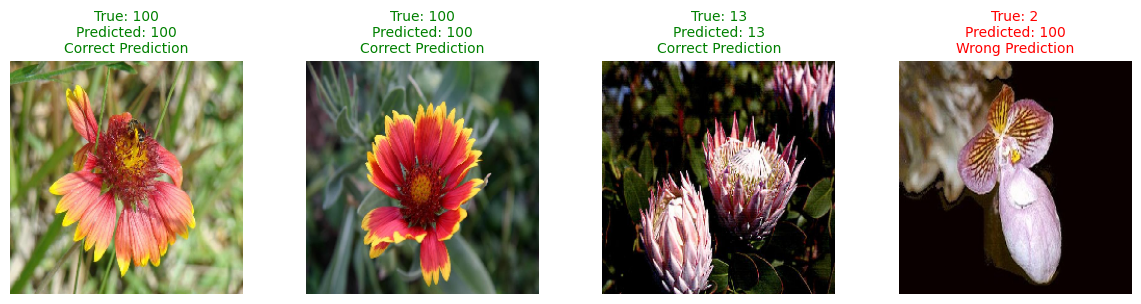

In [ ]:
def display_all_query_predictions(query_images, query_labels, predicted_classes):

    num_samples = len(query_images)
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 3, 3))

    for i in range(num_samples):
        axes[i].imshow(query_images[i])
        axes[i].axis('off')

        true_class = query_labels[i]
        predicted_class = predicted_classes[i]

        # Determine if prediction was correct
        if true_class == predicted_class:
            title_color = "green"
            result_text = "Correct Prediction"
        else:
            title_color = "red"
            result_text = "Wrong Prediction"

        # Set title with class info
        axes[i].set_title(f"True: {true_class}\nPredicted: {predicted_class}\n{result_text}",
                          color=title_color, fontsize=10)

    plt.tight_layout()
    plt.show()

# Display all query images with their predicted class
display_all_query_predictions(query_images, query_labels, predicted_classes)


In [ ]:
# Sahar Abdi